In [16]:
import numpy as np 
import scipy.stats as st
import pymc as pm
import matplotlib.pyplot as plt 
import arviz as az 
import pickle 
import pytensor.tensor as pt


$$ 
\textbf{ data generation}
$$

$$
P(\vec{x}) \sim \mathcal{N}(\vec{\mu}, \Sigma),
$$
$$
P(x, y) \sim \mathcal{N}
\left(
\begin{pmatrix}
\mu_x \\
\mu_y
\end{pmatrix},
\begin{pmatrix}
\sigma_x^2 & \rho \sigma_x \sigma_y \\
\rho \sigma_x \sigma_y  & \sigma_y^2
\end{pmatrix}
\right)
$$

In [17]:
Nobs=10000

In [18]:
mu_t_x=0
mu_t_y=0
sigma_t_y=1
sigma_t_x=1
p_t=0.8
cov = [
    [sigma_t_x**2, p_t * sigma_t_x * sigma_t_y],
    [p_t * sigma_t_x * sigma_t_y, sigma_t_y**2]
]

# Mean vector
mean = [mu_t_x, mu_t_y]

# Generate correlated data
x, y = np.random.multivariate_normal(mean, cov, Nobs).T

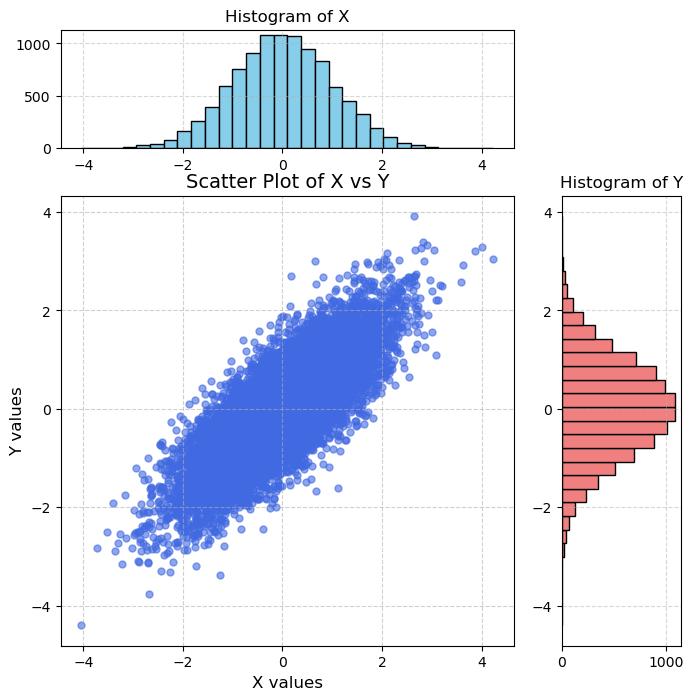

In [19]:

# Create figure and layout
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(4, 4, hspace=0.4, wspace=0.4)

# Scatter plot
main_ax = fig.add_subplot(grid[1:4, 0:3])
main_ax.scatter(x, y, alpha=0.6, color='royalblue', s=25)
main_ax.set_title("Scatter Plot of X vs Y", fontsize=14)
main_ax.set_xlabel("X values", fontsize=12)
main_ax.set_ylabel("Y values", fontsize=12)
main_ax.grid(True, linestyle='--', alpha=0.6)

# Histogram of X (top)
x_hist = fig.add_subplot(grid[0, 0:3], sharex=main_ax)
x_hist.hist(x, bins=30, color='skyblue', edgecolor='k')
x_hist.set_title("Histogram of X", fontsize=12)
x_hist.grid(True, linestyle='--', alpha=0.5)

# Histogram of Y (right)
y_hist = fig.add_subplot(grid[1:4, 3], sharey=main_ax)
y_hist.hist(y, bins=30, orientation='horizontal', color='lightcoral', edgecolor='k')
y_hist.set_title("Histogram of Y", fontsize=12)
y_hist.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [20]:
np.cov(x,y)

array([[0.99794967, 0.79480343],
       [0.79480343, 0.98717374]])


$$
x_i^{(\mathrm{obs})} \sim \mathcal{N}(x_i, \sigma_{x_i}^{(\mathrm{obs})})
$$
$$
y_i^{(\mathrm{obs})} \sim \mathcal{N}(y_i, \sigma_{y_i}^{(\mathrm{obs})})
$$




$$
\textbf{Now observed Quantities}
$$
$$
Y_i^{\text{obs}},X_i^{\text{obs}},\sigma_{Y_i}^{\text{obs}},\sigma_{X_i}^{\text{obs}}
$$
$$


In [21]:
x_obs = np.zeros(Nobs)
y_obs = np.zeros(Nobs)
sigma_obs_y = np.zeros(Nobs)+2
sigma_obs_x = np.zeros(Nobs)+2
p2 = 0  

for i in range(Nobs):
    cov = [
        [sigma_obs_x[i]**2, p2 * sigma_obs_x[i] * sigma_obs_y[i]],
        [p2 * sigma_obs_x[i] * sigma_obs_y[i], sigma_obs_y[i]**2]
    ]
    mean = [x[i], y[i]]
    x_obs[i], y_obs[i] = np.random.multivariate_normal(mean, cov)
sigma_obs_x1=np.mean(sigma_obs_x)
sigma_obs_y1=np.mean(sigma_obs_y)

In [22]:
sigma_obs_x1

np.float64(2.0)

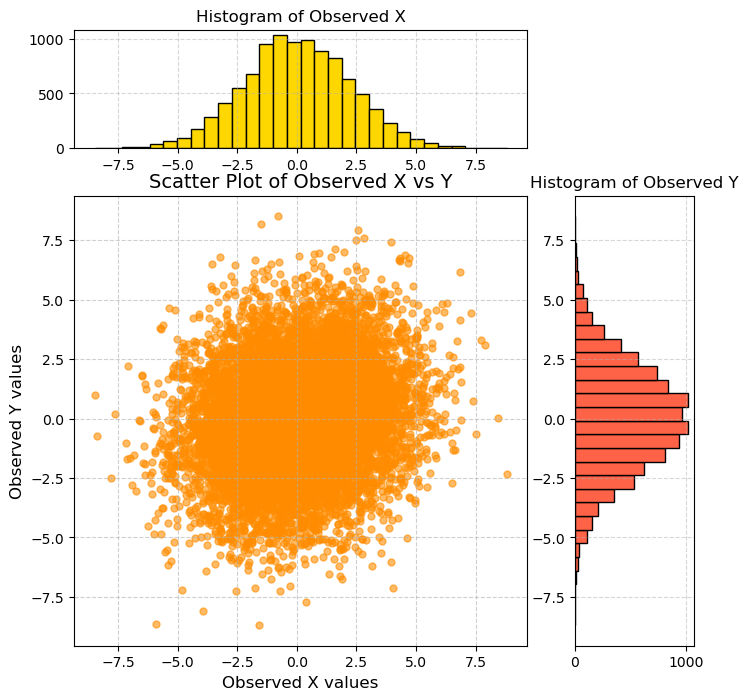

In [23]:
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(4, 4, hspace=0.4, wspace=0.4)
main_ax = fig.add_subplot(grid[1:4, 0:3])
main_ax.scatter(x_obs, y_obs, alpha=0.6, color='darkorange', s=25)
main_ax.set_title("Scatter Plot of Observed X vs Y", fontsize=14)
main_ax.set_xlabel("Observed X values", fontsize=12)
main_ax.set_ylabel("Observed Y values", fontsize=12)
main_ax.grid(True, linestyle='--', alpha=0.6)

# Histogram of X_obs (top)
x_hist = fig.add_subplot(grid[0, 0:3], sharex=main_ax)
x_hist.hist(x_obs, bins=30, color='gold', edgecolor='k')
x_hist.set_title("Histogram of Observed X", fontsize=12)
x_hist.grid(True, linestyle='--', alpha=0.5)

# Histogram of Y_obs (right)
y_hist = fig.add_subplot(grid[1:4, 3], sharey=main_ax)
y_hist.hist(y_obs, bins=30, orientation='horizontal', color='tomato', edgecolor='k')
y_hist.set_title("Histogram of Observed Y", fontsize=12)
y_hist.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [24]:
np.cov(y_obs,x_obs)/(np.std(x)*np.std(y))

array([[5.04032866, 0.82356595],
       [0.82356595, 5.03957952]])

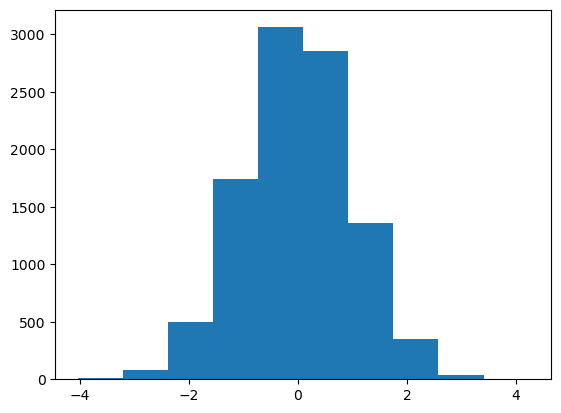

In [25]:
plt.hist(x);

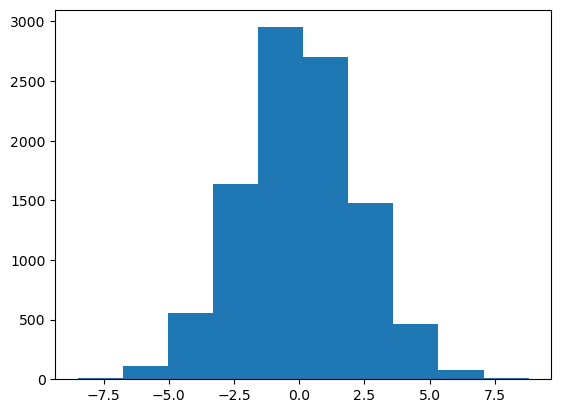

In [26]:
plt.hist(x_obs);

<ErrorbarContainer object of 3 artists>

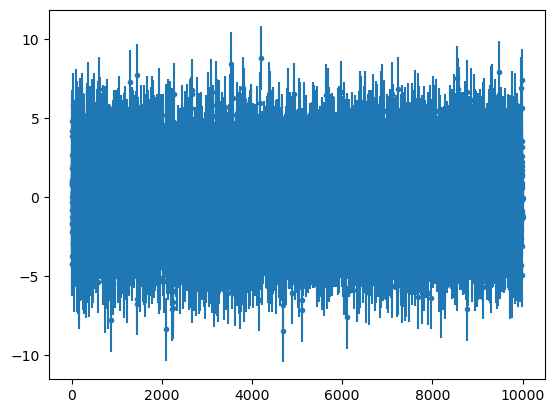

In [27]:
plt.errorbar(np.arange(0,Nobs,1), x_obs, yerr=sigma_obs_x, fmt='.', label='data')

<ErrorbarContainer object of 3 artists>

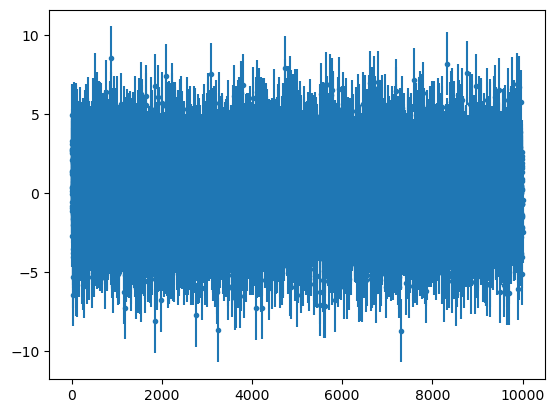

In [28]:
plt.errorbar(np.arange(0,Nobs,1), y_obs, yerr=sigma_obs_y, fmt='.', label='data')


$$
\textbf{Priors}
$$

$$
\mu_x \sim \mathcal{U}(-5, 5)
$$
$$
\mu_y \sim \mathcal{U}(-5, 5)
$$
$$
\sigma_x \sim \mathcal{U}(0, 10)
$$
$$
\sigma_y \sim \mathcal{U}(0, 10)
$$

$$
\textbf{Full Likelihood Expression}
$$

$$
\vec{\Omega} = (\mu_x, \mu_y, \sigma_x, \sigma_y, \rho)
$$

$$
P(\vec{\Omega} \, | \, \vec{x}^{\, \mathrm{obs}}, \vec{y}^{\, \mathrm{obs}}) 
\propto P(\vec{x}^{\, \mathrm{obs}}, \vec{y}^{\, \mathrm{obs}} \, | \, \vec{\Omega}) \, P(\vec{\Omega})
$$

$$
\mathcal{L}(\vec{x}^{\, \mathrm{obs}}, \vec{y}^{\, \mathrm{obs}} \, | \, \vec{\Omega}) 
= \prod_{i=1}^{N_{\mathrm{obs}}} 
\iint P(x_i^{\, \mathrm{obs}} \, | \, x_i) \,
P(y_i^{\, \mathrm{obs}} \, | \, y_i) \,
P(x_i, y_i \, | \, \vec{\Omega}) \, dx_i \, dy_i
$$

$$
\mathcal{L}(\vec{x}^{\, \mathrm{obs}}, \vec{y}^{\, \mathrm{obs}} \, | \, \vec{\Omega})
= \prod_{i=1}^{N_{\mathrm{obs}}}
\iint 
\mathcal{N}_{x_i^{\, \mathrm{obs}}}(x_i, \sigma_{x_i}^{\mathrm{obs}})
\, \mathcal{N}_{y_i^{\, \mathrm{obs}}}(y_i, \sigma_{y_i}^{\mathrm{obs}})
\, \mathcal{N}_{x,y}\!\left(
\begin{pmatrix}
\mu_x \\[4pt] \mu_y
\end{pmatrix},
\begin{pmatrix}
\sigma_x^2 & \rho \sigma_x \sigma_y \\[4pt]
\rho \sigma_x \sigma_y & \sigma_y^2
\end{pmatrix}
\right)
\, dx_i \, dy_i
$$

$$
\mathcal{L}(\vec{x}^{\, \mathrm{obs}}, \vec{y}^{\, \mathrm{obs}} \, | \, \vec{\Omega})
= \prod_{i=1}^{N_{\mathrm{obs}}}
\iint 
\left[
\frac{1}{\sqrt{2\pi (\sigma_{x_i}^{\mathrm{obs}})^2}}
\exp\!\left(-\frac{(x_i^{\, \mathrm{obs}} - x_i)^2}{2 (\sigma_{x_i}^{\mathrm{obs}})^2}\right)
\right] \\
\left[
\frac{1}{\sqrt{2\pi (\sigma_{y_i}^{\mathrm{obs}})^2}}
\exp\!\left(-\frac{(y_i^{\, \mathrm{obs}} - y_i)^2}{2 (\sigma_{y_i}^{\mathrm{obs}})^2}\right)
\right]
$$
$$
\times
\frac{1}{2\pi \sigma_x \sigma_y \sqrt{1 - \rho^2}}
\exp\!\left[
-\frac{1}{2(1 - \rho^2)}
\left(
\frac{(x_i - \mu_x)^2}{\sigma_x^2}
+ \frac{(y_i - \mu_y)^2}{\sigma_y^2}
- \frac{2\rho(x_i - \mu_x)(y_i - \mu_y)}{\sigma_x \sigma_y}
\right)
\right]
dx_i \, dy_i
$$

$$ 
\\ \cdots
$$

$$
\mathcal{L}(\vec{x}^{\,\mathrm{obs}}, \vec{y}^{\,\mathrm{obs}} \mid \vec{\Omega})
= \prod_{i=1}^{N_{\mathrm{obs}}}
\mathcal{N}_{x_i^{obs},y_i^{obs}}
\!\left(
\begin{pmatrix}
\mu_x \\[4pt]
\mu_y
\end{pmatrix},
\begin{pmatrix}
\sigma_x^2 + (\sigma_{x_i}^{\mathrm{obs}})^2 & \rho\sigma_x\sigma_y \\[4pt]
\rho\sigma_x\sigma_y & \sigma_y^2 + (\sigma_{y_i}^{\mathrm{obs}})^2
\end{pmatrix}.
\right)
$$




Posterior :
$$
P\left(\Omega \mid x^{\text{obs}}, y^{\text{obs}}, \sigma_y^{\text{obs}}, \sigma_x^{\text{obs}}\right)
\propto
P(\Omega) \, \mathcal{L}(x^{\text{obs}}, y^{\text{obs}} \mid \Omega)
$$
$$
P\left(\Omega \mid x^{\text{obs}}, y^{\text{obs}}, \sigma_y^{\text{obs}}, \sigma_x^{\text{obs}}\right)
\propto
P(\mu_X)P(\mu_Y) P(\sigma_X) P(\sigma_Y) \, \prod_{i=1}^{N_{\mathrm{obs}}}
\mathcal{N}_{x_i^{obs},y_i^{obs}}
\!\left(
\begin{pmatrix}
\mu_x \\[4pt]
\mu_y
\end{pmatrix},
\begin{pmatrix}
\sigma_x^2 + (\sigma_{x_i}^{\mathrm{obs}})^2 & \rho\sigma_x\sigma_y \\[4pt]
\rho\sigma_x\sigma_y & \sigma_y^2 + (\sigma_{y_i}^{\mathrm{obs}})^2
\end{pmatrix}.
\right)
$$

In [ ]:

data = np.column_stack((x_obs, y_obs))

with pm.Model() as model:
    # Priors
    mu_x = pm.Uniform("mu_x", -5, 5)
    mu_y = pm.Uniform("mu_y", -5, 5)
    sigma_x = pm.Uniform("sigma_x", 0, 5)
    sigma_y = pm.Uniform("sigma_y", 0, 5)
    p = pm.Uniform("p", -1, 1)

    sx = pt.sqrt(sigma_obs_x1**2 + sigma_x**2)
    sy = pt.sqrt(sigma_obs_y1**2 + sigma_y**2)

    # Mean vector
    mu_vec = pt.stack([mu_x, mu_y])


    cov = pt.stacklists([
        [sx**2, p * sigma_x * sigma_y],
        [p * sigma_x * sigma_y, sy**2]
    ])

    obs = pm.MvNormal("obs", mu=mu_vec, cov=cov, observed=data)

    trace = pm.sample(draws=4000, tune=4000, chains=4, cores = 4,target_accept=0.99)


c:\Users\User\anaconda3\envs\dm1\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_x, mu_y, sigma_x, sigma_y, p]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 187 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_x,0.026,0.022,-0.015,0.068,0.000,0.000,14238.0,11717.0,1.0
mu_y,0.010,0.022,-0.032,0.052,0.000,0.000,15270.0,11236.0,1.0
sigma_x,0.999,0.035,0.933,1.066,0.000,0.000,11814.0,8324.0,1.0
sigma_y,1.000,0.036,0.934,1.068,0.000,0.000,12755.0,10931.0,1.0
p,0.818,0.055,0.712,0.922,0.001,0.001,7793.0,4906.0,1.0


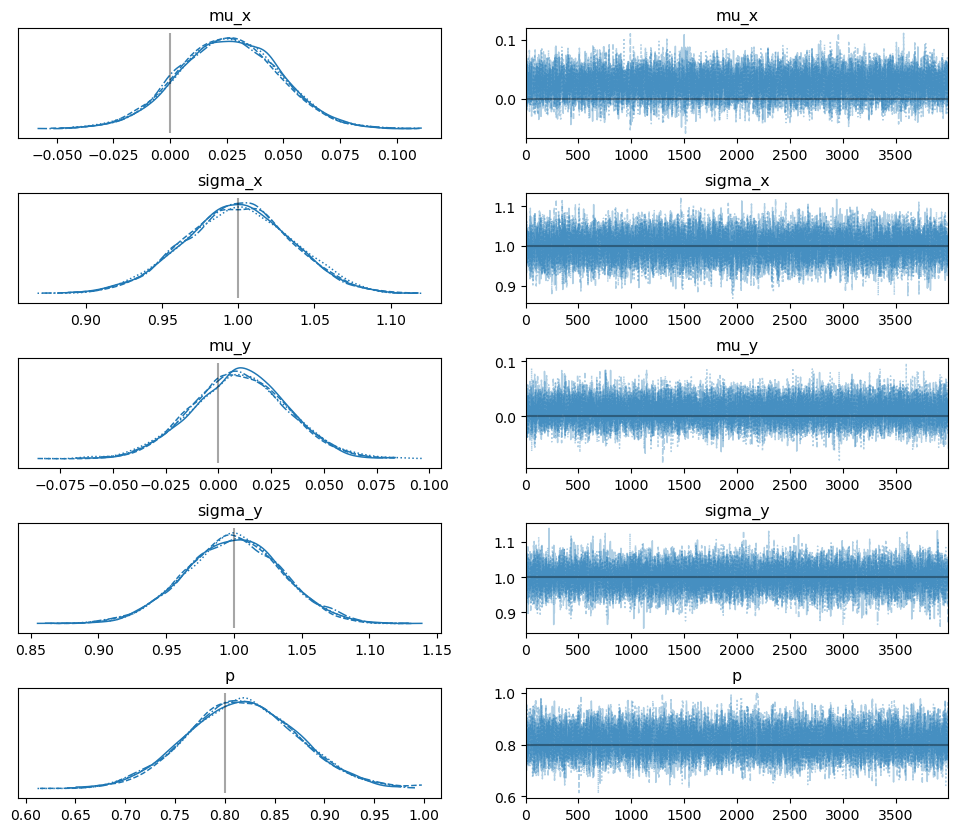

In [30]:
axes=az.plot_trace(            
        trace,
        compact=True,
        var_names=['mu_x', 'sigma_x','mu_y','sigma_y','p'],
        lines=[
            ('mu_x', {}, mu_t_x),         # original mu_P
            ('sigma_x', {}, sigma_t_x),   # original sigma_P
            ('mu_y', {}, mu_t_y),         # original mu_P
            ('sigma_y', {}, sigma_t_y),
            ('p', {}, p_t),

        ]
    )
fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)
az.summary(trace)

x>0,y>0.0
x^2+y^2>r
p vs p2
SNR follows a Chi^2 distribution.
